# 1.Introduction

This notebook contains the sequence to sequence model for unsupervised representation of text using Pytorch. For encoder, a bi-directional Bidirectional LSTM and the decoder uses attention layer and uni-directional LSTM . The source and target language sentences are appended with start of sequence (\<sos\>) and end of sequence (\<eos\>) tokens. NLTK is used for tokenization of English sentences. AdamW optimizer and Cross Entropy Loss Function are used for computation of loss and to update the parameters of the model.

# 2. Installing the required packages

In [2]:
import csv
import torch
import re
import random
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import RegexpTokenizer
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# 3. Pre-processing data

###  English Tokenizers

For tokenization of English sentences, Regexp tokenizer of NLTK is used. This tokenizer is selected for tokenization because while tokenizing it takes care of Apostophe symbol. For example, if the sentence is "I'll be there", then Regexp tokenizer will tokenize it as ["I'll", 'be', 'there'] whereas word_tokenizer() of NLTK will tokenize it as ['I', "'ll", 'be', 'there']. 

In [3]:
regexp_tokenizer= RegexpTokenizer("[m\w']+")
end_punctuation=['.', '!', '?'] 
def english_tokenizer(text_in_english):
  english_tokens=[]
  for token in regexp_tokenizer.tokenize(text_in_english):
    english_tokens.append(token)
  # the Regexp tokenizer doesn't adds the punctuations like ". ! ?" as tokens, so these punctuation marks are added as tokens to english sentences 
  if text_in_english[-1] in end_punctuation:
    english_tokens.append(text_in_english[-1])
  return english_tokens 

### Creating Train and validation set

In [4]:
train_ds=[]
val_ds=[]
with open('/content/gdrive/MyDrive/Unsupervised learning encoder/train.txt', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        train_ds.append([row[0].lower()])

with open('/content/gdrive/MyDrive/Unsupervised learning encoder/valid.txt', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        val_ds.append([row[0]])


In [5]:
train_ds[:10]

[['mr hoagie is an institution .'],
 ['overall '],
 ['excellent food .'],
 ['superb customer service .'],
 ['yes this place is a little out dated and not opened on the weekend .'],
 ['which is always spot on fresh veggies on their hoggies and other food .'],
 ['they also have daily specials and ice cream which is really good .'],
 ['i had a banana split they piled the toppings on .'],
 ['they win pennysaver awards ever years i see why .'],
 ['pros : italian hoagie was delicious .']]

In [6]:
len(val_ds)

9999

# 4.Building the Vocabulary

---



To build the  english vocabulary, first a list of tokens is generated using the tokenizer functions and then checked if the token already exists in the dictioanry. If the token is not present in the dictionary then it is assigned an index and added to the dictionary. . One dictionary maps the word to its corresponding index (word2index) and another maps the index to the corresponding word (index2word). One dictionary is maintained to keep the count of number of occurrences of each word in the corpus. This dictionary can help to limit the size of the vocabulary by keeping the most frequent words in vocabulary.

In [7]:
sos_token='<sos>' # start of sequence token; appended at start of sentence
eos_token='<eos>' # end of sequence token; appended at end of sentence
unk_token='<unk>' # unknown token; used to represent a word if that word is not found in the dictionary
pad_token='<pad>' # token for padding; used to make all sentences of equal length in a batch

In [8]:
# dictionary to keep count of occurrence of each English word
E_wordCount={} 

# dictioanry to find the index for a word in English
E_word2index={sos_token:0, eos_token:1, unk_token:2, pad_token:3}

# dictionary to find the English word for a particular index
E_index2word={0:sos_token, 1:eos_token, 2:unk_token, 3:pad_token}

E_count=4 # keeps count of number of words so far in English dictionary

Defining functions to update the dictionary.

In [9]:
# function to add a word in English dictionary
def E_updateDict(eng_sentence):
  global E_count
  tokens= english_tokenizer(eng_sentence) #generating tokens for the given sentence
  for token in tokens:
    E_wordCount[token]= E_wordCount.get(token,0)+1
    if (token not in E_word2index.keys()): # check if the token already exists in English dictionary
      # if the token is not present in English dictionary then add it to word2index and index2word English dictionary
      E_word2index[token]= E_count
      E_index2word[E_count]=token
      E_count+=1 # increasing the count of words in English vocabulary
    else:
      E_wordCount[token]+=1 # if the token exists in dictionary then simply increase it's count of occurrence

In [10]:
# reading the training pairs to  english vocabulary
for pair in train_ds:
  # print(pair)
  E_updateDict(pair[0]) # updating english vocabulary

In [11]:
eng_sentence= "it's got that nice "
print(english_tokenizer(eng_sentence))

["it's", 'got', 'that', 'nice']


In [12]:
# number of words in  english vocabulary
print(E_count) 

26630


# 5. Model Architecture

#### Defining the Encoder architecture
For encoder a bidirectional LSTM is used, where the forward RNN goes over the embedded sentence from left to right and the backward RNN goes over the embedded sentence from right to left. Due to bidirectional nature of encoder, we get two context vectors, one corresponding to each RNN. However, since the decoder used is unidirectional LSTM, so these context vectors are concatenated together through a linear layer and then the tanh activation function is applied.

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, dropout_val):
        super().__init__()
        self.dropout = nn.Dropout(dropout_val)
        self.embedding = nn.Embedding(input_size, embedding_size)
        # to make the LSTM bidirectional we pass bidirectional=True parameter
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True)
        # fully connected linear layer
        self.linear_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.linear_cell = nn.Linear(hidden_size * 2, hidden_size)
        # self.linear_output = nn.Linear(hidden_size * 2, hidden_size)
        
    def forward(self, token_vec):  
        #token_vec is a vector of indices mapping a word to its index in the vocabulary. token_vec.shape()=[max_batch_length, batch size]
        
        embedding = self.dropout(self.embedding(token_vec)) #embedding is a 3D tensor of shape (seq length, batch_size, embedding_size)
        
        encoder_outputs, (encoder_hidden, encoder_cell) = self.lstm(embedding) # the embedding is passed as input to the LSTM
        # encoder_outputs has dimensions [seq length, batch size, 2*hidden_size]
        # encoder_hidden has dimensions [2, batch_size, hidden_size]
        # in encoder_outputs, encoder_hidden and encoder_cell we have 2 due to the bidirectional nature of LSTM encoder. These are hidden states of both the forward RNN and backward RNN.
        
        # concatinating the hidden states of both the layers using a linear layer and then applying tanh activation function
        # encoder_hidden[-2,:,:] represents the hidden states from forward layer and encoder_hidden[-1,:,:] represents the hidden states from backward layer after the final time step

        encoder_hidden = self.linear_hidden(torch.cat((encoder_hidden[0:1], encoder_hidden[1:2]), dim = 2))
        encoder_cell = self.linear_cell(torch.cat((encoder_cell[0:1], encoder_cell[1:2]), dim = 2))
        return encoder_hidden, encoder_cell 

Definning the Decoder architecture

In [14]:
class Decoder(nn.Module):
    def __init__(self, embedding_size, hidden_size, output_size,num_layers, dropout_val):
        super().__init__()
        self.output_size = output_size
        self.dropout = nn.Dropout(dropout_val)
        self.embedding = nn.Embedding(output_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=dropout_val)
        self.linear_decoder = nn.Linear(hidden_size , output_size)        
        
    def forward(self, token_vec, hidden, cell): 
        #token_vec is one dimensional i.e. shape(token_vec) = (batch_size), hidden is a 2D vector of shape [batch_size, hidden_size] 
        #encoder_outputs have shape [seq len, batch_size, 2*hidden_size]
        token_vec = token_vec.unsqueeze(0) # unsqueeze adds one more dimension to token_vec
        embedding = self.dropout(self.embedding(token_vec)) #embedding is a 3D tensor of shape (1, batch_size, embedding_size)
        outputs, (hidden,cell) = self.lstm(embedding, (hidden,cell)) # hidden and cell states are used to determine the next word in the sequence and output is the current predicted word. 
        predictions = self.linear_decoder(outputs) # shape(outputs)= (1, batch size, hidden size), shape(predictions)= (1, batch_size, english vocabulary size)
        predictions = predictions.squeeze(0) #remove the one extra dimension which was added using unsqueeze. 
        return predictions, hidden, cell

Defining the Seq2Seq class to define the model architecture

In [15]:
class seq2seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()     
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, input_token, target_token, teacher_force_ratio = 0): #teacher_force_ratio helps in preventing the model from overfitting and underfitting.
        # teacher_force_ratio helps in deciding whether the next input word to the decoder will be actual/target word or the previous predicted word. 
        # input_token is tensor of [seq length, batch_size] shape and target_token has shape [target_length, batch-size]
        
        batch_size = input_token.shape[1] 
        target_len = target_token.shape[0]
        english_dict_size = self.decoder.output_size
        
        #tensor to store decoder outputs, it is initially initialised to all zeroes
        predicted_vector = torch.zeros(target_len, batch_size, english_dict_size).to(self.device)
        hidden, cell = self.encoder(input_token)
        # encoder output stores all the hidden states in the input sequence both in forward and backward direction and hidden stores forward and backward hidden states after the final time step
        token_vec = target_token[0,:] #appending the <sos> token in prediction vector
        
        for i in range(1, target_len):
            output_token, hidden, cell = self.decoder(token_vec, hidden, cell)  #embedded input token, previous hidden states and encoder hidden states are passed to the decoder to obtain the prediction
            predicted_vector[i] = output_token #output is appended to the prediction tokens
     
            if (random.random() < teacher_force_ratio): #half of the times this will be true if teacher_force_ratio is 0.5
              token_vec= target_token[i] #in this case next input to the decoder is target/actual word
            else:
              token_vec= output_token.argmax(1) #in this case next input to the decoder is predicted word

        return predicted_vector

# 6. Training the Model

Setting optimal hyperparameters for Training

In [16]:
#Hyperparameters
batch_size = 128
learning_rate = 0.001
epochs =35
epoch_loss=0.0 # training loss in each epoch
layers = 1 # number of neural network layers in rnn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = E_count
output_size = E_count
hidden_size = 100 # encoder and decoder have same hidden size
embedding_size = 100 # encoder and decoder embedding size
dropout = 0.5 # encoder and decoder dropout value

**Preparing data for training the Model:**  To create batches of same length, I calculated the maximum length of sentence in a batch and stored this value in a dictionary with key as batch_id. After obtaining the maximum length for each batch, "\<pad\>" token was appended to the sentences whose length was less than the maximum length of sentence in that batch. After that, Dataloader is used to create batches of the required batch size. Each batch will have sentences of same length.

In [18]:

train_ds.sort(key= lambda x: len(x[0])) 

In [19]:
# finding the maximum length of sentence in a batch
max_length_train={} # stores maximum length of sentences in training data
batch_id=1
# computing maximum length for each batch of training data
for i in range(0,len(train_ds),batch_size):
  max_len=0 
  for pair in train_ds[i:i+batch_size]:
    E_maxlength=0
    H_maxlength=0
    for token in english_tokenizer(pair[0]):
      E_maxlength+=1
    max_len=max(max_len,E_maxlength )
  max_length_train[batch_id]=max_len+2
  batch_id+=1

max_length_test={} # stores maximum length of sentences in test/validation data
batch_id=1
# computing maximum length for each batch of validation data
for i in range(0,len(val_ds),batch_size):
  max_len=0
  for pair in val_ds[i:i+batch_size]:
    E_maxlength=0
    for token in english_tokenizer(pair[0]):
      E_maxlength+=1
    max_len=max(max_len,E_maxlength )
  max_length_test[batch_id]=max_len+2
  batch_id+=1   

In [20]:

# E_sentenceToTensor function takes a sentence, maximum length as argument and returns a tensor of indices with padding done, if required.
def E_sentenceToTensor(sentence,max_length):
  # append start of sequence token at beginning
  trg_index=[E_word2index['<sos>']]
  for token in english_tokenizer(sentence):
    # if the word in not present in dictionary then index corresponding to unknown token '<unk>' i.e. 2 is used
    trg_index.append(E_word2index.get(token,2))
  # append end of sequence token
  trg_index.append(E_word2index['<eos>'])
  # check if length of sentence is less than maximum length, if yes, then append <pad> token
  if(len(trg_index)<max_length): 
    while(len(trg_index)!=max_length):
      trg_index.append(E_word2index['<pad>'])
  return torch.Tensor(trg_index) # returning tensor of indices with length equal to max_length

In [21]:
train_tensor=[] 
test_tensor=[] # stores tensor of indexes of validation/test data

# finding tensor of indexes of training data
batch_id=1
for i in range(0,len(train_ds),batch_size):
  max_len=max_length_train[batch_id]
  for pair in train_ds[i:i+batch_size]:
    source_tensor=E_sentenceToTensor(pair[0],max_len)
    target_tensor=E_sentenceToTensor(pair[0],max_len)
    train_tensor.append([source_tensor, target_tensor])
  batch_id+=1

# finding tensor of indexes of validation/test data
batch_id=1
for i in range(0,len(val_ds),batch_size):
  max_len=max_length_test[batch_id]
  for pair in val_ds[i:i+batch_size]:
    source_tensor=E_sentenceToTensor(pair[0],max_len)
    target_tensor=E_sentenceToTensor(pair[0],max_len)
    test_tensor.append([source_tensor, target_tensor])
  batch_id+=1

In [22]:
# finding train and test iterator using data loader
# shuffle=false is used so that data remains sorted in batches
train_iterator = DataLoader(train_tensor, batch_size=batch_size,shuffle=False) 
test_iterator = DataLoader(test_tensor, batch_size=batch_size,shuffle=False)

In [23]:
# function to evaluate the validation loss in each epoch
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, (x,y) in enumerate(iterator):
      input_sentence = x.long() 
      target_sentence = y.long()
      # input_sentence and target_sentence have shape = (batch_size, maximum length) but we need shape to be (maximum length, batch_size ) so they are transposed
      input_sentence=torch.transpose(input_sentence, 0, 1).to(device)
      target_sentence=torch.transpose(target_sentence, 0, 1).to(device)
      
      output = model(input_sentence, target_sentence, 0) #turn off teacher forcing
      output_dim = output.shape[2]
      output = output[1:].reshape(-1, output_dim)
      
      
      target_sentence = target_sentence[1:].reshape(-1)
      loss = criterion(output, target_sentence)
      # print(" o:",output.shape,"t:",target_sentence.shape)
      epoch_loss += loss.item()
      del target_sentence,output,input_sentence
  return epoch_loss / len(iterator)

In [ ]:

# evaluate(model,test_iterator,criterion)

In [ ]:
# defining path to store the model in different epochs
path = "/content/gdrive/MyDrive/Unsupervised learning encoder/final_phase.pth"
path5 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch5.pth"
path10 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch10.pth"
path15 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch15.pth"
path20 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch20.pth"
path25 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch25.pth"
path30 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch30.pth"
path35 = "/content/gdrive/MyDrive/Unsupervised learning encoder/epoch35.pth"

In [ ]:
num_layers=1
encoder = Encoder(input_size,embedding_size, hidden_size, dropout).to(device)
decoder = Decoder(embedding_size, hidden_size, output_size, num_layers, dropout).to(device)

# model = seq2seq(encoder, decoder, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
pad_index = E_word2index['<pad>'] #finding the index of token <pad> in english vocabulary
criterion = nn.CrossEntropyLoss(ignore_index = pad_index) #padding token is being ignored while loss computation because we don't want to pay price for <pad> token
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # AdamW optimizer is used 
step = 0

Initialising the weights of the model using Normal distribution with mean 0 and standard deviation 0.01.

In [ ]:
def init_weights(model):
    for name, parameter in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(parameter.data, mean=0, std=0.01)
        else:
            nn.init.constant_(parameter.data, 0)
            
model.apply(init_weights)

seq2seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(26630, 100)
    (lstm): LSTM(100, 100, bidirectional=True)
    (linear_hidden): Linear(in_features=200, out_features=100, bias=True)
    (linear_cell): Linear(in_features=200, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(26630, 100)
    (lstm): LSTM(100, 100, dropout=0.5)
    (linear_decoder): Linear(in_features=100, out_features=26630, bias=True)
  )
)

The model is stored after every 5 epochs and then prediction on validation set is generated from these models. 

In [ ]:
train_loss={}
validation_loss={}

In [ ]:
for epoch in range(1,epochs+1):
    epoch_loss=0
    print(f"[Epoch {epoch} / {epochs}]")
    model.eval()
    model.train()
    i=0
    for id, (x,y) in enumerate(train_iterator):   # iterating over batches of train_iterator
      input_sentence = x.long()
      target_sentence = y.long()

      # input_sentence and target_sentence have shape = (batch_size, maximum length) but we need shape to be (maximum length, batch_size ) so they are transposed
      input_sentence=torch.transpose(input_sentence, 0, 1).to(device)
      target_sentence=torch.transpose(target_sentence, 0, 1).to(device)
    
      output = model(input_sentence, target_sentence) #forward propagation
      output = output[1:].view(-1, output.shape[-1]) #removing the start token from model's prediction and reshaping it to make it make it fit for input to loss function
      
      target_sentence = target_sentence[1:].reshape(-1) #removing the start token from actual target translation
      optimizer.zero_grad() 
      loss = criterion(output, target_sentence)
    
      loss.backward() #backward propagation
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # clipping the gradients to keep them in reasonable range
      optimizer.step() #gradient descent. The optimizer iterates over all parameters (tensors) to be updated and their internally stored gradients are used.
      del target_sentence,output,input_sentence
      step += 1
      epoch_loss+=loss.item() # adding the epoch loss for each batch
    if(epoch==5): # saving the model after every 5 epochs 
      torch.save(model,path5)
    elif(epoch==10):
      torch.save(model,path10)
    elif(epoch==15):
      torch.save(model,path15)
    elif(epoch==20):
      torch.save(model,path20)
    elif(epoch==25):
      torch.save(model,path25)
    elif(epoch==30):
      torch.save(model,path30)
    elif(epoch==35):
      torch.save(model,path35)    

    val_loss=evaluate(model, test_iterator, criterion)
    train_loss[epoch]=epoch_loss/len(train_iterator)
    validation_loss[epoch]=val_loss
    print("Train loss : ", epoch_loss/len(train_iterator))
    print("Validation loss : ", val_loss)

[Epoch 1 / 35]
Train loss :  5.562154792168166
Validation loss :  6.09140648419344
[Epoch 2 / 35]
Train loss :  4.7516379118613985
Validation loss :  6.1825319181514695
[Epoch 3 / 35]
Train loss :  4.220394510797255
Validation loss :  6.509695493722264
[Epoch 4 / 35]
Train loss :  3.5697066026834516
Validation loss :  4.986676590352118
[Epoch 5 / 35]
Train loss :  2.953568760012482
Validation loss :  4.27609068834329
[Epoch 6 / 35]
Train loss :  2.5031863510494268
Validation loss :  3.7387991042076787
[Epoch 7 / 35]
Train loss :  2.1731341021830812
Validation loss :  3.5221651656718196
[Epoch 8 / 35]
Train loss :  1.9183806344480638
Validation loss :  3.310403534128696
[Epoch 9 / 35]
Train loss :  1.706978832007763
Validation loss :  3.14088642144505
[Epoch 10 / 35]
Train loss :  1.5323518751980967
Validation loss :  2.9639221625992014
[Epoch 11 / 35]
Train loss :  1.391983035066169
Validation loss :  2.83123287671729
[Epoch 12 / 35]
Train loss :  1.2723543482594977
Validation loss :  

# **PART A :Training loss per epoch and validation loss per epoch**

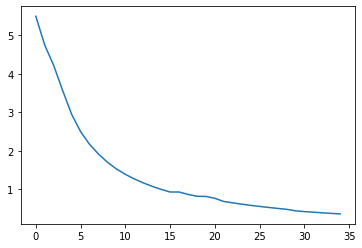

In [ ]:
#plot for training loss per epoch 
import matplotlib.pyplot as plt

plt.plot(range(epochs),train_lossloss)

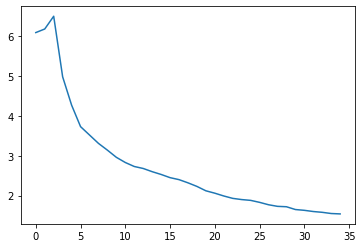

In [ ]:
#validation loss per epoch plot
import matplotlib.pyplot as plt

plt.plot(range(epochs),validation_loss)

In [ ]:

model.eval()

In [ ]:
model = torch.load("/content/gdrive/MyDrive/Unsupervised learning encoder/epoch35.pth") #loading the model

In [ ]:
model.eval()

seq2seq(
  (encoder): Encoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(26630, 100)
    (lstm): LSTM(100, 100, bidirectional=True)
    (linear_hidden): Linear(in_features=200, out_features=100, bias=True)
    (linear_cell): Linear(in_features=200, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (embedding): Embedding(26630, 100)
    (lstm): LSTM(100, 100, dropout=0.5)
    (linear_decoder): Linear(in_features=100, out_features=26630, bias=True)
  )
)

# **Part B: testing the model (BLEU Score and Constructionloss)**

In [24]:
test_ds=[]
with open('/content/gdrive/MyDrive/Unsupervised learning encoder/test.txt', 'r') as f: #reading the train.csv file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        test_ds.append([row[0]])


In [25]:
len(test_ds)

10000

In [26]:

max_length_test1={} # stores maximum length of sentences in test/validation data
batch_id=1
# computing maximum length for each batch of validation data
for i in range(0,len(test_ds),batch_size):
  max_len=0
  for pair in test_ds[i:i+batch_size]:
    E_maxlength=0
    for token in english_tokenizer(pair[0]):
      E_maxlength+=1
    max_len=max(max_len,E_maxlength )
  max_length_test1[batch_id]=max_len+2
  batch_id+=1  

In [27]:
test1_tensor=[]
batch_id=1
for i in range(0,len(test_ds),batch_size):
  max_len=max_length_test1[batch_id]
  for pair in test_ds[i:i+batch_size]:
    source_tensor=E_sentenceToTensor(pair[0],max_len)
    target_tensor=E_sentenceToTensor(pair[0],max_len)
    test1_tensor.append([source_tensor, target_tensor])
  batch_id+=1

In [28]:
test1_iterator = DataLoader(test1_tensor, batch_size=batch_size,shuffle=False)
# test_iterator=DataLoader(test_tensor, batch_size=batch_size,shuffle=False)


In [ ]:
print(test1_iterator)

In [ ]:
test1_loss=evaluate(model, test1_iterator, criterion)

In [ ]:
# train_loss=evaluate(model, train_iterator, criterion)


In [ ]:
print("test construction loss :",test1_loss)


test construction loss 1.5028739171692087


# **BLEU score**

In [ ]:
def predictions(model, device, num_vec, max_length=70):
    i_tensor = torch.LongTensor(num_vec).unsqueeze(1).to(device)
    with torch.no_grad():
        hidden,cell = model.encoder(i_tensor)
    o_num_vec = [E_word2index["<sos>"]] # adding index for <sos> token
    eos_idx=E_word2index["<eos>"] # adding index for <eos> token
    for _ in range(max_length):
        curr_input = torch.LongTensor([o_num_vec[-1]]).to(device)
        with torch.no_grad():
            output, hidden,cell = model.decoder(curr_input,hidden,cell)
            curr_output = output.argmax(1).item()
        o_num_vec.append(curr_output) # appending the prediction in english index vector
        if (curr_output == eos_idx): # stop generating predictions once eos token is encountered
            break
    return o_num_vec

In [ ]:
pred_data=[]
test_data=[]
file=open("/content/gdrive/MyDrive/Unsupervised learning encoder/test.txt")
for row in file:

    sentence_token=[]

    for t in english_tokenizer(row):
        sentence_token.append(t)
    s=[]
    for i in sentence_token:
      s.append(i)
    test_data.append(s)
  
    sentence_token.insert(0,'<sos>') # append <sos> token
    sentence_token.append('<eos>') # append <eos> token
    num_vec = []

    for t in sentence_token:
      num_vec.append(E_word2index.get(t,2))
    o = predictions(model, device, num_vec, max_length=70)
    t=[]
    for i in o:
      if(i!=E_word2index['<sos>'] and i!=E_word2index['<eos>']):
        t.append(E_index2word[i])
    pred_data.append(t)

#pred_data contains the output of autoencoder for each sentence 
#test_data cotains our actual sentence

In [ ]:
pred_data[0]

['husband', "'s", 'the', 'thin', 'crust', 'pizza']

In [ ]:
test_data[0]

['husband', 'loves', 'the', 'thin', 'crust', 'pizza']

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
bleu=0
for i in range(len(test_data)): 
  bleu=bleu+sentence_bleu([test_data[i]],pred_data[i])
print("bleu score :",bleu/len(test_data))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


bleu score : 0.5903284119197079


# **Part C:  effect of Teacher Forcing(value = 1.0)**

In [29]:
path = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tfinal_phase.pth"
path5 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch5.pth"
path10 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch10.pth"
path15 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch15.pth"
path20 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch20.pth"
path25 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch25.pth"
path30 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch30.pth"
path35 = "/content/gdrive/MyDrive/Unsupervised learning encoder/Tepoch35.pth"

In [ ]:
num_layers=1
encoder1 = Encoder(input_size,embedding_size, hidden_size, dropout).to(device)
decoder1 = Decoder(embedding_size, hidden_size, output_size, num_layers, dropout).to(device)

model2 = seq2seq(encoder1, decoder1, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [30]:
pad_index = E_word2index['<pad>'] #finding the index of token <pad> in english vocabulary
criterion = nn.CrossEntropyLoss(ignore_index = pad_index) #padding token is being ignored while loss computation because we don't want to pay price for <pad> token
optimizer = optim.AdamW(model2.parameters(), lr=learning_rate) # AdamW optimizer is used 
step = 0

In [ ]:

print(" USING TEACHER FORING VALUE 1.0")
print("---------------------------------------------------------")
print(" ")
epochs=35
train_loss_T={}
validation_loss_T={}
for epoch in range(1,epochs+1):
    epoch_loss=0
    print(f"[Epoch {epoch} / {epochs}]")
    model2.eval()
    model2.train()
    i=0
    for id, (x,y) in enumerate(train_iterator):   # iterating over batches of train_iterator
      input_sentence = x.long()
      target_sentence = y.long()


      # input_sentence and target_sentence have shape = (batch_size, maximum length) but we need shape to be (maximum length, batch_size ) so they are transposed
      input_sentence=torch.transpose(input_sentence, 0, 1).to(device)
      target_sentence=torch.transpose(target_sentence, 0, 1).to(device)
    
      output = model2(input_sentence, target_sentence,1) #forward propagation ,here we are passing TEACHER FORCING VALUE =1
      output = output[1:].view(-1, output.shape[-1]) #removing the start token from model's prediction and reshaping it to make it make it fit for input to loss function
      
      target_sentence = target_sentence[1:].reshape(-1) #removing the start token from actual target translation
      optimizer.zero_grad() 
      loss = criterion(output, target_sentence)
    
      loss.backward() #backward propagation
      torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1) # clipping the gradients to keep them in reasonable range
      optimizer.step() #gradient descent. The optimizer iterates over all parameters (tensors) to be updated and their internally stored gradients are used.
      del target_sentence,output,input_sentence
      step += 1
      epoch_loss+=loss.item() # adding the epoch loss for each batch
    if(epoch==5): # saving the model after every 5 epochs 
      torch.save(model2,path5)
    elif(epoch==10):
      torch.save(model2,path10)
    elif(epoch==15):
      torch.save(model2,path15)
    elif(epoch==20):
      torch.save(model2,path20)
    elif(epoch==25):
      torch.save(model2,path25)
    elif(epoch==30):
      torch.save(model2,path30)
    elif(epoch==35):
      torch.save(model2,path35)    

    val_loss=evaluate(model2, test_iterator, criterion)
    train_loss_T[epoch]=epoch_loss/len(train_iterator)
    validation_loss_T[epoch]=val_loss
    print("Train loss : ", epoch_loss/len(train_iterator))
    print("Validation loss : ", val_loss)


 USING TEACHER FORING VALUE 1.0
---------------------------------------------------------
 
[Epoch 1 / 35]
Train loss :  2.4727652980966113
Validation loss :  4.837183922151976
[Epoch 2 / 35]
Train loss :  2.2452922065070338
Validation loss :  4.452825250504892
[Epoch 3 / 35]
Train loss :  2.055819299366659
Validation loss :  4.249923531013199
[Epoch 4 / 35]
Train loss :  1.8977678258536612
Validation loss :  4.150815200202072
[Epoch 5 / 35]
Train loss :  1.7674802461737102
Validation loss :  3.982766676552688
[Epoch 6 / 35]
Train loss :  1.6534349877490517
Validation loss :  3.856082116501241
[Epoch 7 / 35]
Train loss :  1.5550754124691994
Validation loss :  3.735140586201149
[Epoch 8 / 35]
Train loss :  1.4679421268285513
Validation loss :  3.6411471940294096
[Epoch 9 / 35]
Train loss :  1.388859811215222
Validation loss :  3.4890904969806913
[Epoch 10 / 35]
Train loss :  1.3177181912970384
Validation loss :  3.4689025637469713
[Epoch 11 / 35]
Train loss :  1.2539308722122222
Validat

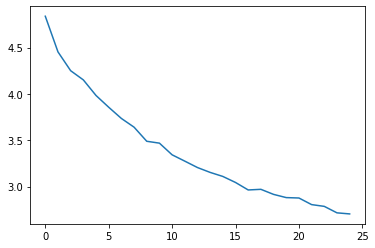

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(validation_loss_T)),validation_loss_T)

In [33]:
#finding construction loss when teacher forcing is on

test1_loss_tf=evaluate(model2, test1_iterator, criterion)
print("Contruction loss ",test1_loss_tf)

Contruction loss  2.873520452


In [31]:
model2=torch.load(path25)

# **Part D :  Use the learned model to generate unsupervised representation on the sentiment analysis dataset inthe yelp folder. Do a dimensionality reduction and visualize it using a 2-D scatter plot along with their labels.**

In [ ]:
#loading the initial model with TF
model = torch.load("/content/gdrive/MyDrive/Unsupervised learning encoder/epoch35.pth",map_location=torch.device('cpu')) #loading the model

In [ ]:
def encode_sen(model, device, num_vec, max_length=70):
    input_tensor = torch.LongTensor(num_vec).unsqueeze(1).to(device)
    with torch.no_grad():
        hidden, cell = model.encoder(input_tensor)
    return  hidden

**loading  train data for sentiment analysis and generate unsupervised representation on the sentiment analysis dataset**

In [ ]:

file1 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.pos') 
file2 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.neg') 
X_pos=[]
for row in file1:
    sentence_token=[]

    for t in english_tokenizer(row):
        sentence_token.append(t)
  
    sentence_token.insert(0,'<sos>') # append <sos> token
    sentence_token.append('<eos>') # append <eos> token
    num_vec = []

    for t in sentence_token:
      num_vec.append(E_word2index.get(t,2))
    o = encode_sen(model, device, num_vec, max_length=70)
    X_pos.append(o.tolist())


In [ ]:
X_neg=[]
file2 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.neg') 

for row in file2:

    sentence_token=[]

    for t in english_tokenizer(row):
        sentence_token.append(t)
  
    sentence_token.insert(0,'<sos>') # append <sos> token
    sentence_token.append('<eos>') # append <eos> token
    num_vec = []

    for t in sentence_token:
      num_vec.append(E_word2index.get(t,2))
    o = encode_sen(model, device, num_vec, max_length=70)
    X_neg.append(o.tolist())

In [ ]:
X_pos1=[]
for i in range(len(X_pos)):
  X_pos1.append(X_pos[i][0][0])

In [ ]:
X_neg1=[]
for i in range(len(X_neg)):
  X_neg1.append(X_neg[i][0][0])

In [ ]:
len(X_neg1)

1000

In [ ]:
X_pos_train=np.array(X_pos1)
X_neg_train=np.array(X_neg1)

 **Dimensionality Reduction**: PCA on 1000.pos and 1000.neg (training set)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train=np.concatenate((X_neg_train, X_pos_train), axis=0)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train_pca=pca.transform(X_train)

In [ ]:
X_train

array([[-0.8180517 , -0.67564875,  0.39001629, ..., -1.31605041,
         0.10060634,  1.00651693],
       [-0.92009127, -0.7396692 ,  0.19025946, ..., -0.46276528,
        -0.5930838 ,  1.15511012],
       [-0.28933513, -0.21861875,  0.15973473, ..., -0.66461241,
        -1.00040317,  0.57332754],
       ...,
       [-1.41459894, -0.56252623, -0.41333222, ..., -1.31920123,
        -1.29779172,  1.46074486],
       [-0.2253527 ,  0.34019592,  0.26021671, ..., -1.257985  ,
        -1.05847132,  0.66860235],
       [-0.65315759, -0.51418775,  0.57157981, ..., -0.92462647,
        -0.50319868,  0.76330864]])

# **Plotting the data**

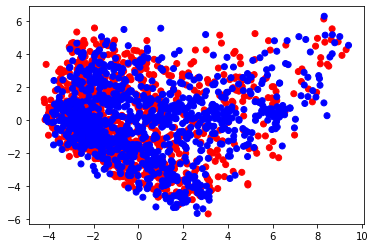

In [ ]:
import matplotlib.pyplot as plt

color=[]
Y_pos=[1]*1000
Y_neg=[0]*1000
Y_train=Y_neg + Y_pos
color=[]
for i in range(len(Y_train)):
  if(Y_train[i]==1):
    color.append("blue")
  else:
    color.append("red")
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c=color)

# plt.scatter(features[:,0],features[:,1],c=color,marker="x")


# **PART E:Train a logistic regression classifier on the representations from the earlier task and report the classification accuracy on files 100.pos and 100.neg.**

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,max_iter=200).fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#accuracy on training data
print("accuracy on training set",clf.score(X_train,Y_train))

accuracy on training set 0.75


**loading test set and preprocess**

In [ ]:
file3 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/100.pos') 
file4 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/100.neg') 
X_pos_test=[]
for row in file3:

    sentence_token=[]

    for t in english_tokenizer(row):
        sentence_token.append(t)
  
    sentence_token.insert(0,'<sos>') # append <sos> token
    sentence_token.append('<eos>') # append <eos> token
    num_vec = []

    for t in sentence_token:
      num_vec.append(E_word2index.get(t,2))
    o = encode_sen(model, device, num_vec, max_length=70)
    X_pos_test.append(o.tolist())
X1=[]
for i in range(len(X_pos_test)):
  X1.append(X_pos_test[i][0][0])
X_testP=np.array(X1)
X_testP.shape

#loading 100.neg
X_neg_test=[]
for row in file4:

    sentence_token=[]

    for t in english_tokenizer(row):
        sentence_token.append(t)
  
    sentence_token.insert(0,'<sos>') # append <sos> token
    sentence_token.append('<eos>') # append <eos> token
    num_vec = []

    for t in sentence_token:
      num_vec.append(E_word2index.get(t,2))
    o = encode_sen(model, device, num_vec, max_length=70)
    X_neg_test.append(o.tolist())
X2=[]
for i in range(len(X_neg_test)):
  X2.append(X_neg_test[i][0][0])
X_testN=np.array(X1)
X_testN.shape





(100, 100)

In [ ]:
X_test=np.concatenate((X_testP, X_testN), axis=0)
y_test=[1]*100+[0]*100

In [ ]:
len(y_test)

200

# **testing classification performance on test data**

In [ ]:
print("accuracy on testing set",clf.score(X_test,y_test))

accuracy on testing set 0.72


# **PART F: LSTM BASED TEXT CLASSIFIER**

#defining Model architecture

In [7]:
class TextClassifier(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, dropout_val):
        super().__init__()
        self.dropout = nn.Dropout(dropout_val)
        self.embedding = nn.Embedding(input_size, embedding_size)
        # to make the LSTM bidirectional we pass bidirectional=True parameter
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional = True)
        # fully connected linear layer
        self.linear_hidden = nn.Linear(hidden_size * 2, 2)
        self.softmax=nn.Softmax(2)
        
    def forward(self, token_vec):  
        #token_vec is a vector of indices mapping a word to its index in the vocabulary. token_vec.shape()=[max_batch_length, batch size]
        
        embedding = self.dropout(self.embedding(token_vec)) #embedding is a 3D tensor of shape (seq length, batch_size, embedding_size)
        
        encoder_outputs, (encoder_hidden, encoder_cell) = self.lstm(embedding) # the embedding is passed as input to the LSTM
        # in encoder_outputs, encoder_hidden and encoder_cell we have 2 due to the bidirectional nature of LSTM encoder. These are hidden states of both the forward RNN and backward RNN.

        y = self.linear_hidden(torch.cat((encoder_hidden[0:1], encoder_hidden[1:2]), dim = 2))
        y=self.softmax(y)
        return y

**Loading training data**

In [ ]:
file1 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.pos') 
file2 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.neg') 
train_data=[]
with open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.pos', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        train_data.append([row[0].lower()])

with open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.neg', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        train_data.append([row[0]])




In [ ]:
len(train_data)

2000

In [ ]:
train_tensor=[] 
# finding tensor of indexes of training data
i=0
for i in range(0,len(train_data),batch_size):
  max_len=50
  for pair in train_data[i:i+batch_size]:
    if(i==2000):
      break
    if(i<1000):
      y=1
    else:
      y=0
    source_tensor=E_sentenceToTensor(pair[0],max_len)
    train_tensor.append([source_tensor,y])
    i=i+1

In [ ]:
len(train_tensor)

2000

In [ ]:
train_iter = DataLoader(train_tensor, batch_size=batch_size,shuffle=True) 


**#Training the Model**

In [ ]:
classifier=TextClassifier(input_size,embedding_size, hidden_size, dropout).to(device)

In [5]:
path="/content/gdrive/MyDrive/Unsupervised learning encoder/LSTM.pth"
pad_index = E_word2index['<pad>'] #finding the index of token <pad> in english vocabulary
criterion = nn.CrossEntropyLoss(ignore_index = pad_index) #padding token is being ignored while loss computation because we don't want to pay price for <pad> token
optimizer = optim.AdamW(classifier.parameters(), lr=learning_rate) # AdamW optimizer is used 
step = 0

In [ ]:
train_loss=[]
epochs=100
for epoch in range(1,epochs+1):
    epoch_loss=0
    print(f"[Epoch {epoch} / {epochs}]")
    # model.eval()
    # model.train()
    i=0
    for id, (x,y) in enumerate(train_iter):   # iterating over batches of train_iterator
      input_sentence = x.long()
      # input_sentence and target_sentence have shape = (batch_size, maximum length) but we need shape to be (maximum length, batch_size ) so they are transposed
      input_sentence=torch.transpose(input_sentence, 0, 1).to(device)

      output =classifier(input_sentence) #forward propagation
      # print(y.shape)
      y = y.to(device)
      output = torch.squeeze(output) 
      # print(output.shape)
      optimizer.zero_grad() 
      loss = criterion(output, y)
    
      loss.backward() #backward propagation
      torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1) # clipping the gradients to keep them in reasonable range
      optimizer.step() #gradient descent. The optimizer iterates over all parameters (tensors) to be updated and their internally stored gradients are used.
      del output,input_sentence
      step += 1
      epoch_loss+=loss.item() # adding the epoch loss for each batch
    # if(epoch==5): # saving the model after every 5 epochs 
    #   torch.save(model,path5)
    # elif(epoch==10):
    #   torch.save(model,path10)
    # elif(epoch==15):
    #   torch.save(model,path15)
    # elif(epoch==20):
    #   torch.save(model,path20)
    # elif(epoch==25):
    #   torch.save(model,path25)
    # elif(epoch==30):
    #   torch.save(model,path30)
    # elif(epoch==35):
    #   torch.save(model,path35)    

    # val_loss=evaluate(model, test_iterator, criterion)
    train_loss.append(epoch_loss/len(train_iter))
    # validation_loss[epoch]=val_loss
    print("Train loss : ", epoch_loss/len(train_iter))
    # print("Validation loss : ", val_loss)

[Epoch 1 / 100]
Train loss :  0.3352406192570925
[Epoch 2 / 100]
Train loss :  0.3412248585373163
[Epoch 3 / 100]
Train loss :  0.33660560101270676
[Epoch 4 / 100]
Train loss :  0.3382800668478012
[Epoch 5 / 100]
Train loss :  0.3377098962664604
[Epoch 6 / 100]
Train loss :  0.33795899525284767
[Epoch 7 / 100]
Train loss :  0.3379580192267895
[Epoch 8 / 100]
Train loss :  0.3381540235131979
[Epoch 9 / 100]
Train loss :  0.3412804324179888
[Epoch 10 / 100]
Train loss :  0.33656646870076656
[Epoch 11 / 100]
Train loss :  0.33855815418064594
[Epoch 12 / 100]
Train loss :  0.33752672374248505
[Epoch 13 / 100]
Train loss :  0.3380460310727358
[Epoch 14 / 100]
Train loss :  0.34345471300184727
[Epoch 15 / 100]
Train loss :  0.3375020083039999
[Epoch 16 / 100]
Train loss :  0.3364537972956896
[Epoch 17 / 100]
Train loss :  0.3327263072133064
[Epoch 18 / 100]
Train loss :  0.33615279756486416
[Epoch 19 / 100]
Train loss :  0.3309409115463495
[Epoch 20 / 100]
Train loss :  0.3335505276918411
[E

In [9]:
#saving the model
torch.save(classifier,path)

**#testing the LSTM classifier**

In [10]:
classifier=torch.load(path)

In [11]:
classifier.eval()

TextClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (embedding): Embedding(26630, 100)
  (lstm): LSTM(100, 100, bidirectional=True)
  (linear_hidden): Linear(in_features=200, out_features=2, bias=True)
  (softmax): Softmax(dim=2)
)

In [ ]:
file3 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.pos') 
file4 = open('/content/gdrive/MyDrive/Unsupervised learning encoder/1000.neg') 
test_data=[]
with open('/content/gdrive/MyDrive/Unsupervised learning encoder/100.pos', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        test_data.append([row[0].lower()])

with open('/content/gdrive/MyDrive/Unsupervised learning encoder/100.neg', 'r') as f: #reading the train file
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
      if(len(row[0])>0):
        test_data.append([row[0]])




In [ ]:
len(test_data)

200

In [ ]:
test_tensor=[] 
# finding tensor of indexes of training data
i=0
for i in range(0,len(train_data),batch_size):
  max_len=50
  for pair in test_data[i:i+batch_size]:
    if(i==200):
      break
    if(i<100):
      y=1
    else:
      y=0
    source_tensor=E_sentenceToTensor(pair[0],max_len)
    test_tensor.append([source_tensor,y])
    i=i+1

In [ ]:
test_iter = DataLoader(test_tensor, batch_size=batch_size,shuffle=True) 


**#accuracy on training data**

In [ ]:
c=0
for id,(x,y) in enumerate(train_iter):
  input_sentence = x.long()
  input_sentence=torch.transpose(input_sentence, 0, 1).to(device)

  output =classifier(input_sentence) #forward propagation
  # print(y.shape)
  y = y.to(device)
  output = torch.squeeze(output) 
  out=np.array(output.tolist())
  y=np.array(y.tolist())
  for i in range(len(out)):
    if(out[i].argmax()==y[i]):
      c=c+1
  
  # print(output.shape)
  del output,input_sentence
print("acccuracy on training data",c/len(train_data)*100)


acccuracy on training data 98.6


**Accuracy on testing data**

In [ ]:
c=0
for id,(x,y) in enumerate(test_iter):
  input_sentence = x.long()
  input_sentence=torch.transpose(input_sentence, 0, 1).to(device)

  output =classifier(input_sentence) #forward propagation
  # print(y.shape)
  y = y.to(device)
  output = torch.squeeze(output) 
  out=np.array(output.tolist())
  y=np.array(y.tolist())
  for i in range(len(out)):
    if(out[i].argmax()==y[i]):
      c=c+1
  
  # print(output.shape)
  del output,input_sentence
print("acccuracy on testing data",c/len(test_data)*100)


acccuracy on testing data 82.5


# 9. References


[1] [https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
